In [2]:
from mesa import Model, Agent
from mesa.datacollection import DataCollector
import random
import math
import numpy as np

def compute_team_diversity(team):
    """
    Calculates diversity as the average pairwise absolute difference
    across all cultural traits (PDI, IDV, UAI, LTO).
    """
    if len(team) <= 1:
        return 0

    traits = ['PDI', 'IDV', 'UAI', 'LTO']
    total_dist = 0.0
    count = 0

    for i, a1 in enumerate(team):
        for a2 in team[i+1:]:
            for trait in traits:
                total_dist += abs(getattr(a1, trait) - getattr(a2, trait))
                count += 1

    # Normalize to [0, 1]
    avg_dist = total_dist / count  # max possible per trait is 1
    return avg_dist

def tuckman_stage_modifier(progress_fraction):
    """
    Returns modifiers for team effectiveness based on Tuckman's stages.
    Maps project progress to team development stages.
    """
    # Determine which stage the team is in based on progress
    if progress_fraction < 0.25:  # Forming (0-25%)
        productivity = 0.6       # Lower productivity during orientation
    
    elif progress_fraction < 0.5:  # Storming (20-50%)
        productivity = 0.5       # Lowest productivity due to conflicts
    
    elif progress_fraction < 0.75:  # Norming (50-75%)
        productivity = 0.8       # Productivity improves significantly

    else:  # Performing (70-100%)
        productivity = 1.0       # Maximum productivity
    
    return {
        'productivity': productivity,
    }


class WorkerAgent(Agent):
    def __init__(self, model, country, PDI, IDV, UAI, LTO):
        super().__init__(model)
        self.country = country
        self.PDI = PDI
        self.IDV = IDV
        self.UAI = UAI
        self.LTO = LTO
        self.working = True
        self.quality = 0
        self.task_progress = 0
        self.meeting_steps = 0

    def step(self):
        if self.meeting_steps > 0:
            self.meeting_steps -= 1
            return

        manager = self.model.manager_location.get(self)
        if manager:
            self.meeting_steps = max(1, int((self.PDI * 0.2 + 1)))
            return
        
        task_type = self.model.get_task_type(self)

        progress_fraction = self.model.total_progress / 100


        # Apply Tuckman stage modifiers
        tuckman = tuckman_stage_modifier(progress_fraction)


        # Simplified base performance based on direct trait mapping
        if task_type == 'innovative':
            base_perf = self.IDV
        elif task_type == 'routine':
            base_perf = self.PDI
        elif task_type == 'long_term':
            base_perf = self.LTO
        elif task_type == 'flexible':
            base_perf = self.UAI
        elif task_type == 'urgent':
            base_perf = 1 - self.IDV
        elif task_type == 'hierarchical_alignment':
            base_perf = 1 - self.PDI
        elif task_type == 'adaptability':
            base_perf = 1 - self.UAI
        elif task_type == 'short_term_pragmatism':
            base_perf = 1 - self.LTO
        else:
            base_perf = random.random()

        # Slight uncertainty in performance
        base_perf *= random.uniform(0.95, 1.05)
        
        # Get teammates and calculate interaction bonus
        teammates = self.model.get_team()



        # Use the new interaction_success function that includes progress_fraction
        interaction_bonus = sum(
            interaction_success(self, other, progress_fraction) for other in teammates if other != self
        ) / (len(teammates) - 1) if len(teammates) > 1 else 0

        # Apply Tuckman modifiers to efficiency
        base_efficiency = base_perf + 0.2 * interaction_bonus

        # Determine current stage
        current_stage = "forming"
        if progress_fraction < 0.25:
            current_stage = "forming"
        elif progress_fraction < 0.5:
            current_stage = "storming"
        elif progress_fraction < 0.75:
            current_stage = "norming"
        else:
            current_stage = "performing"

        # Calculate final efficiency with Tuckman modifiers
        efficiency = (base_efficiency * tuckman['productivity'])
        

        # Apply progress and quality modifiers
        progress_shape = cultural_progress_modifier(self.model, progress_fraction)
        adjusted_progress = efficiency * progress_shape
        
        # Storming phase especially affects mixed teams (culture clashes)
        dynamic_diversity = compute_team_diversity(self.model.get_team()) # nyttttt
        if current_stage == 'storming' and dynamic_diversity > 0.5:
            storming_penalty = 0.2 * dynamic_diversity
            adjusted_progress *= (1 - storming_penalty)

        self.task_progress += adjusted_progress

        quality_shape = cultural_quality_modifier(self.model, progress_fraction)
        quality_contribution = efficiency * quality_shape

        # More diverse teams eventually reach higher quality in performing stage
        if current_stage == 'performing' and dynamic_diversity > 0.3:
            diversity_bonus = 0.15 * dynamic_diversity
            quality_contribution *= (1 + diversity_bonus)

        self.quality += quality_contribution


class ManagerAgent(Agent):
    def __init__(self, model):
        super().__init__(model)

    def step(self):
        for worker in self.model.get_team():
            if random.random() < self.get_attention_prob(worker):
                self.model.manager_location[worker] = self

    def get_attention_prob(self, worker):
        return (worker.PDI + (1 - worker.IDV)) / 2


class TeamModel(Model):
    def __init__(self, team_profile, seed=None):
        super().__init__(seed=seed)
        self.manager_location = {}
        self.custom_agents = []
        self.team_profile = team_profile
        self.total_progress = 0
        self.steps = 0
        

        for profile in team_profile:
            agent = WorkerAgent(self, **profile)
            self.custom_agents.append(agent)

        self.manager = ManagerAgent(self)
        self.custom_agents.append(self.manager)

        self.datacollector = DataCollector(
            model_reporters={
                "AvgQuality": lambda m: sum(a.quality for a in m.get_team()) / len(m.get_team()),
                "TotalProgress": lambda m: m.total_progress,
                "TeamDiversity": lambda m: m.team_diversity,
                "CurrentStage": lambda m: self.get_current_stage(),
                "StageEfficiency": lambda m: self.get_stage_efficiency()
            }
        )
    
        self.team_diversity = compute_team_diversity(self.get_team())
        self.avg_PDI = sum(a.PDI for a in self.get_team()) / len(self.get_team())
        self.avg_IDV = sum(a.IDV for a in self.get_team()) / len(self.get_team())
        self.avg_UAI = sum(a.UAI for a in self.get_team()) / len(self.get_team())
        self.avg_LTO = sum(a.LTO for a in self.get_team()) / len(self.get_team())

    def get_current_stage(self):
        progress_fraction = self.total_progress / 100

        # Base thresholds
        forming_threshold = 0.25
        storming_threshold = 0.5
        norming_threshold = 0.75

        # Adjust storming threshold based on diveristy
        # more diveres teams need more porgress to exit storming
        diversity_adjustment = 0.1 * self.team_diversity
        storming_threshold += diversity_adjustment
        norming_threshold += diversity_adjustment * 0.5 # Smaller effect on later stages

        if progress_fraction < forming_threshold:
            return "Forming"
        elif progress_fraction < storming_threshold:
            return "Storming"
        elif progress_fraction < norming_threshold:
            return "Norming"
        else:
            return "Performing"

    def get_stage_efficiency(self):
        progress_fraction = self.total_progress / 100
        tuckman = tuckman_stage_modifier(progress_fraction)
        return tuckman['productivity']


    def step(self):
        if self.total_progress >= 100:
            return

        self.manager_location = {}
        self.manager.step()
        step_progress = 0

        for agent in self.get_team():
            agent.step()
            step_progress += agent.task_progress
            agent.task_progress = 0

        self.total_progress += step_progress / len(self.get_team())
        self.total_progress = min(self.total_progress, 100)
        self.datacollector.collect(self)

        self.steps += 1

    def get_team(self):
        return [a for a in self.custom_agents if isinstance(a, WorkerAgent)]

    def get_task_type(self, agent):
        task_types = [
            "innovative",
            "routine",
            "long_term",
            "flexible",
            "urgent",
            "hierarchical_alignment",
            "adaptability",
            "short_term_pragmatism"
        ]
        return task_types[self.steps % len(task_types)]


def interaction_success(agent1, agent2, progress_fraction):
    """
    Calculate interaction success between two agents based on:
    1. Cultural dimension similarity with stage-appropriate weighting
    2. Clear theoretical foundation in Tuckman's stages
    """
    # Calculate normalized cultural distance (0-1 scale)
    dimensions = ['PDI', 'IDV', 'UAI', 'LTO']
    cultural_distances = [abs(getattr(agent1, dim) - getattr(agent2, dim)) for dim in dimensions]
    avg_cultural_distance = sum(cultural_distances) / len(dimensions)
    similarity = 1 - avg_cultural_distance
    
    # Apply stage-appropriate modifier based on Tuckman's model
    # Literature suggests that cultural differences impact early stages more
    if progress_fraction < 0.25:  # Forming
        stage_modifier = 0.7  # Cultural differences have strong impact
    elif progress_fraction < 0.5:  # Storming
        stage_modifier = 0.8  # Impact decreases slightly
    elif progress_fraction < 0.75:  # Norming
        stage_modifier = 0.9  # Team adapts to differences
    else:  # Performing
        stage_modifier = 1.0  # Cultural differences no longer impede success
    
    # Add language/customs barrier for cross-cultural interactions
    # This effect diminishes as team develops
    cross_cultural_penalty = 0.0
    if agent1.country != agent2.country:
        cross_cultural_penalty = 0.2 * (1 - progress_fraction)
    
    # Calculate final score
    interaction_score = (similarity * stage_modifier) - cross_cultural_penalty
    
    return max(0.1, min(1.0, interaction_score))  # Bound between 0.1 and 1.0


def cultural_progress_modifier(model, progress_fraction):
    """
    Rebalanced modifier for how cultural dimensions affect progress rate.
    """
    PDI = model.avg_PDI
    IDV = model.avg_IDV
    LTO = model.avg_LTO
    
    # Reduce IDV's impact on early advantage
    early_factor = 1 + (IDV - 0.5) * 0.3 * (1 - progress_fraction)
    
    # Keep PDI's middle stage effect but reduce magnitude
    middle_factor = 1 + (0.5 - PDI) * 0.3 * (1 - abs(progress_fraction - 0.5))
    
    # Make LTO matter in late stages but less dramatically
    late_factor = 1 + (LTO - 0.5) * 0.3 * progress_fraction
    
    # Geometric mean provides better behavior as a multiplier
    combined_effect = (early_factor * middle_factor * late_factor) ** (1/3)
    
    return max(0.8, min(1.2, combined_effect))  # Tighter bounds


def cultural_quality_modifier(model, progress_fraction):
    """
    Rebalanced modifier for how cultural dimensions affect work quality.
    """
    IDV = model.avg_IDV
    UAI = model.avg_UAI
    LTO = model.avg_LTO
    PDI = model.avg_PDI  # Added PDI as a quality factor
    
    # Reduce UAI's impact on quality (currently favoring Brazil)
    # Early stage: Balance collectivism with innovation (IDV effect)
    early_factor = 1 + (0.5 - IDV) * 0.5 * (1 - progress_fraction)
    
    # Middle stage: Reduce UAI's impact on middle-stage quality
    middle_factor = 1 + (UAI - 0.5) * 0.2 * (1 - abs(progress_fraction - 0.5))
    
    # Late stage: Make LTO and education/development matter more
    # This proxy blends LTO with "development factor" (inverse PDI)
    development_factor = (LTO + (1 - PDI)) / 2  # Blend of long-term and development
    late_factor = 1 + (development_factor - 0.5) * 0.6 * progress_fraction
    
    # Geometric mean provides better behavior as a multiplier
    combined_effect = (early_factor * middle_factor * late_factor) ** (1/3)
    
    return max(0.7, min(1.3, combined_effect))  # Tighter bounds

c:\Users\Daniel\Desktop\CogSci_Bachelor\Workplace_ABM\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
#------------------------------- TEAM GENERATION FUNCTIONS --------------------------------------------------- #

def generate_aus_profile():
    rng = np.random.default_rng()
    return {
        "country": "Australia",
        "PDI": np.clip(rng.normal(loc=0.38, scale=0.15), 0, 1),
        "IDV": np.clip(rng.normal(loc=0.73, scale=0.15), 0, 1),
        "UAI": np.clip(rng.normal(loc=0.51, scale=0.15), 0, 1),
        "LTO": np.clip(rng.normal(loc=0.56, scale=0.15), 0, 1)
    }

def generate_us_profile():
    rng = np.random.default_rng()
    return {
        "country": "USA",
        "PDI": np.clip(rng.normal(loc=0.40, scale=0.15), 0, 1),
        "IDV": np.clip(rng.normal(loc=0.60, scale=0.15), 0, 1),
        "UAI": np.clip(rng.normal(loc=0.46, scale=0.15), 0, 1),
        "LTO": np.clip(rng.normal(loc=0.50, scale=0.15), 0, 1)
    }

def generate_brazil_profile():
    rng = np.random.default_rng()
    return {
        "country": "Brazil",
        "PDI": np.clip(rng.normal(loc=0.69, scale=0.15), 0, 1),
        "IDV": np.clip(rng.normal(loc=0.36, scale=0.15), 0, 1),
        "UAI": np.clip(rng.normal(loc=0.76, scale=0.15), 0, 1),
        "LTO": np.clip(rng.normal(loc=0.28, scale=0.15), 0, 1)
    }

def generate_china_profile():
    rng = np.random.default_rng()
    return {
        "country": "China",
        "PDI": np.clip(rng.normal(loc=0.80, scale=0.15), 0, 1),
        "IDV": np.clip(rng.normal(loc=0.43, scale=0.15), 0, 1),
        "UAI": np.clip(rng.normal(loc=0.30, scale=0.15), 0, 1),
        "LTO": np.clip(rng.normal(loc=0.77, scale=0.15), 0, 1)
    }

def generate_ger_profile():
    rng = np.random.default_rng()
    return {
        "country": "Germany",
        "PDI": np.clip(rng.normal(loc=0.35, scale=0.15), 0, 1),
        "IDV": np.clip(rng.normal(loc=0.79, scale=0.15), 0, 1),
        "UAI": np.clip(rng.normal(loc=0.65, scale=0.15), 0, 1),
        "LTO": np.clip(rng.normal(loc=0.57, scale=0.15), 0, 1)
    }


def generate_sa_profile():
    rng = np.random.default_rng()
    return {
        "country": "South Africa",
        "PDI": np.clip(rng.normal(loc=0.49, scale=0.15), 0, 1),
        "IDV": np.clip(rng.normal(loc=0.23, scale=0.15), 0, 1),
        "UAI": np.clip(rng.normal(loc=0.49, scale=0.15), 0, 1),
        "LTO": np.clip(rng.normal(loc=0.18, scale=0.15), 0, 1)
    }


def generate_mixed_team(n_agents):
    countries = [
        ("Germany", generate_ger_profile),
        ("USA",     generate_us_profile),
        ("Brazil",  generate_brazil_profile),
        ("China",   generate_china_profile),
        ("South Africa", generate_sa_profile),
        ("Australia", generate_aus_profile)
    ]
    n_countries = len(countries)
    base = n_agents // n_countries
    remainder = n_agents % n_countries

    team = []
    for i, (name, gen_func) in enumerate(countries):
        count = base + (1 if i < remainder else 0)  # distribute remainder fairly
        team.extend([gen_func() for _ in range(count)])
    
    random.shuffle(team)
    return team

# Western cultures team
def generate_western_team(n_agents):
    agents_per_country = n_agents // 3
    team = []
    team.extend([generate_aus_profile() for _ in range(agents_per_country)])
    team.extend([generate_us_profile() for _ in range(agents_per_country)])
    team.extend([generate_ger_profile() for _ in range(agents_per_country)])
    
    # Add remaining agents
    remaining = n_agents - len(team)
    if remaining > 0:
        generator_funcs = [generate_aus_profile, generate_us_profile, generate_ger_profile]
        for _ in range(remaining):
            team.append(random.choice(generator_funcs)())
    
    return team

# Eastern/developing economies team
def generate_eastern_team(n_agents):
    agents_per_country = n_agents // 3
    team = []
    team.extend([generate_brazil_profile() for _ in range(agents_per_country)])
    team.extend([generate_china_profile() for _ in range(agents_per_country)])
    team.extend([generate_sa_profile() for _ in range(agents_per_country)])
    
    # Add remaining agents
    remaining = n_agents - len(team)
    if remaining > 0:
        generator_funcs = [generate_brazil_profile, generate_china_profile, generate_sa_profile]
        for _ in range(remaining):
            team.append(random.choice(generator_funcs)())
    
    return team

# High IDV team
def generate_high_idv_team(n_agents):
    team = []
    team.extend([generate_ger_profile() for _ in range(n_agents // 2)])  # ~50%
    team.extend([generate_aus_profile() for _ in range(n_agents // 4)])  # ~25% 
    team.extend([generate_us_profile() for _ in range(n_agents - len(team))])  # Remainder
    return team

# Low PDI team
def generate_low_pdi_team(n_agents):
    team = []
    team.extend([generate_aus_profile() for _ in range(n_agents // 2)])  # ~50%
    team.extend([generate_ger_profile() for _ in range(n_agents // 4)])  # ~25%
    team.extend([generate_us_profile() for _ in range(n_agents - len(team))])  # Remainder
    return team

# High UAI team
def generate_high_uai_team(n_agents):
    team = []
    team.extend([generate_brazil_profile() for _ in range(n_agents // 2)])  # ~50%
    team.extend([generate_ger_profile() for _ in range(n_agents // 4)])  # ~25%
    team.extend([generate_china_profile() for _ in range(n_agents - len(team))])  # Remainder
    return team

# Balanced LTO team
def generate_balanced_lto_team(n_agents):
    team = []
    team.extend([generate_china_profile() for _ in range(n_agents // 3)])  # ~33%
    team.extend([generate_ger_profile() for _ in range(n_agents // 3)])  # ~33%
    team.extend([generate_sa_profile() for _ in range(n_agents - len(team))])  # Remainder
    return team

# Optimal mix based on our analysis
def generate_optimal_team(n_agents):
    team = []
    # Fast workers (Germany + Australia)
    team.extend([generate_ger_profile() for _ in range(n_agents // 6)])
    team.extend([generate_aus_profile() for _ in range(n_agents // 6)])
    
    # Quality focus (Brazil + South Africa)
    team.extend([generate_brazil_profile() for _ in range(n_agents // 6)])
    team.extend([generate_sa_profile() for _ in range(n_agents // 6)])
    
    # Balance (China + USA)
    team.extend([generate_china_profile() for _ in range(n_agents // 6)])
    team.extend([generate_us_profile() for _ in range(n_agents - len(team))])
    
    return team

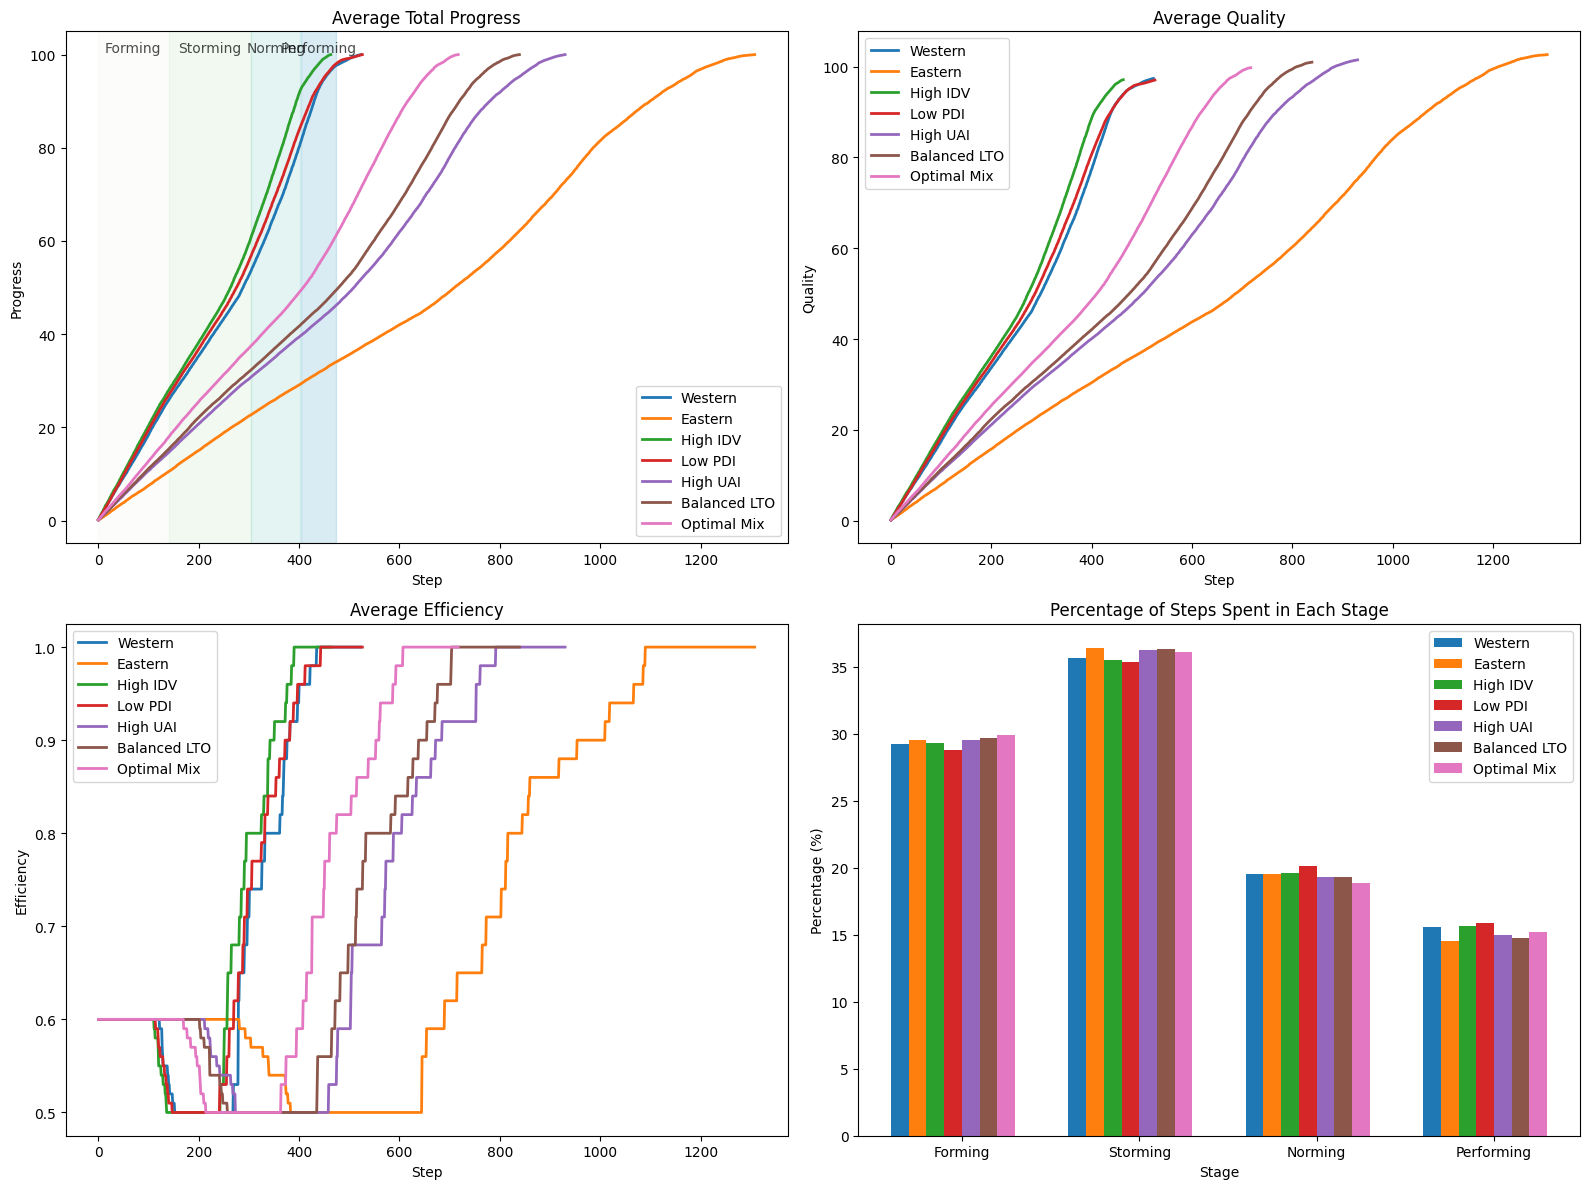

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import random

# Settings
N_SIMULATIONS = 10
N_AGENTS = 12

team_generators = {
    "Western":   lambda: generate_western_team(N_AGENTS),
    "Eastern":   lambda: generate_eastern_team(N_AGENTS),
    "High IDV":  lambda: generate_high_idv_team(N_AGENTS),
    "Low PDI":   lambda: generate_low_pdi_team(N_AGENTS),
    "High UAI":  lambda: generate_high_uai_team(N_AGENTS),
    "Balanced LTO": lambda: generate_balanced_lto_team(N_AGENTS),
    "Optimal Mix": lambda: generate_optimal_team(N_AGENTS)
    }

# Accumulators
progress_runs = defaultdict(list)
quality_runs = defaultdict(list)
efficiency_runs = defaultdict(list)
stage_runs = defaultdict(list)
steps_per_stage = {team: defaultdict(int) for team in team_generators}

# Run all simulations
for sim in range(N_SIMULATIONS):
    for team_name, generator in team_generators.items():
        model = TeamModel(generator())
        while model.total_progress < 100:
            model.step()
        df = model.datacollector.get_model_vars_dataframe()

        # store full time series
        progress_runs[team_name].append(df["TotalProgress"].values)
        quality_runs[team_name].append(df["AvgQuality"].values)
        efficiency_runs[team_name].append(df["StageEfficiency"].values)
        stage_runs[team_name].append(df["CurrentStage"].values)

        # accumulate step counts per stage
        for st in df["CurrentStage"]:
            steps_per_stage[team_name][st] += 1

# Average over time series
def average_over_runs(data_dict):
    avg_dict = {}
    for team, runs in data_dict.items():
        max_len = max(len(r) for r in runs)
        padded = [np.pad(r, (0, max_len - len(r)), mode='edge') for r in runs]
        avg_dict[team] = np.mean(padded, axis=0)
    return avg_dict

avg_progress = average_over_runs(progress_runs)
avg_quality = average_over_runs(quality_runs)
avg_efficiency = average_over_runs(efficiency_runs)

# Use first simulation from Germany as stage layout
ref_stages = stage_runs["Western"][0]
boundaries = np.where(ref_stages[:-1] != ref_stages[1:])[0] + 1
stage_seq = [ref_stages[0]] + [ref_stages[i] for i in boundaries]
unique_stages = []
for s in stage_seq:
    if s not in unique_stages:
        unique_stages.append(s)

stage_colors = dict(zip(unique_stages, ['#f0f9e8','#bae4bc','#7bccc4','#43a2ca']))

# Plotting
fig, axes = plt.subplots(2, 2, figsize=(16,12))
ax1, ax2, ax3, ax4 = axes.flatten()
xsteps = np.arange(len(ref_stages))

# 1) Progress with shaded Tuckman stages
for s in unique_stages:
    mask = (ref_stages == s)
    runs = np.split(xsteps[mask], np.where(np.diff(xsteps[mask])!=1)[0]+1)
    for run in runs:
        ax1.axvspan(run[0], run[-1], color=stage_colors[s], alpha=0.2)
for name, prog in avg_progress.items():
    ax1.plot(prog, lw=2, label=name)
ymax = ax1.get_ylim()[1]
for s in unique_stages:
    xs = xsteps[ref_stages == s]
    if len(xs)==0: continue
    ax1.text(xs.mean(), ymax*0.98, s, ha='center', va='top', fontsize=10, alpha=0.7)
ax1.set(title="Average Total Progress", xlabel="Step", ylabel="Progress")
ax1.legend(loc='lower right')

# 2) Average Quality
for name, q in avg_quality.items():
    ax2.plot(q, lw=2, label=name)
ax2.set(title="Average Quality", xlabel="Step", ylabel="Quality")
ax2.legend(loc='upper left')

# 3) Average Efficiency
for name, e in avg_efficiency.items():
    ax3.plot(e, lw=2, label=name)
ax3.set(title="Average Efficiency", xlabel="Step", ylabel="Efficiency")
ax3.legend(loc='upper left')

# 4) Stage step percentages (bar chart)
stage_names = ['Forming','Storming','Norming','Performing']
bar_width = 0.1
x = np.arange(len(stage_names))

for i, team in enumerate(team_generators):
    total_steps = sum(steps_per_stage[team][st] for st in stage_names)
    percentages = [(steps_per_stage[team][st] / total_steps) * 100 for st in stage_names]
    
    ax4.bar(x + (i - len(team_generators)/2)*bar_width,
            percentages, bar_width, label=team)

ax4.set(title="Percentage of Steps Spent in Each Stage",
        xlabel="Stage", ylabel="Percentage (%)",
        xticks=x, xticklabels=stage_names)
ax4.legend(loc='upper right')

plt.tight_layout()
plt.show()


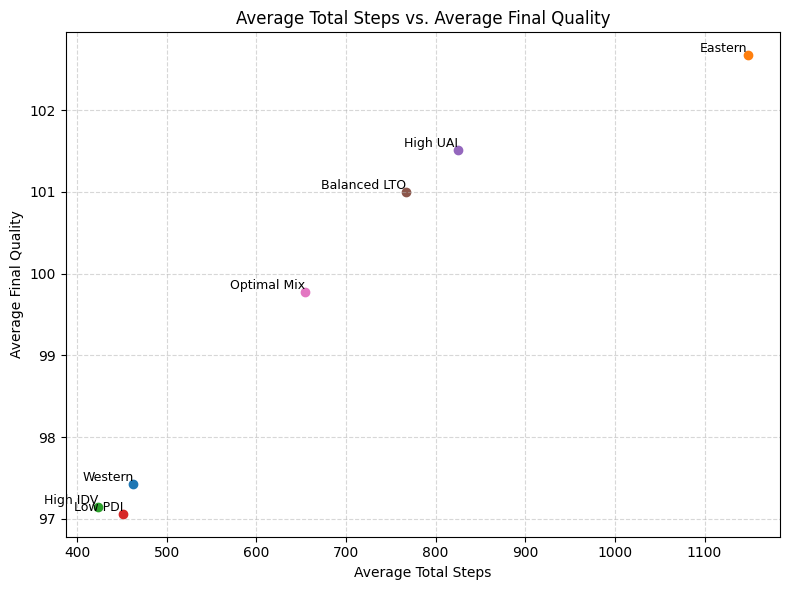

In [12]:
# 1) Compute average total steps per team
#    (each run’s length is the number of steps it took to hit 100% progress)
avg_steps = {
    team: np.mean([len(r) for r in progress_runs[team]])
    for team in progress_runs
}

# 2) Compute average final quality per team
#    (take the last quality value from each run, then average)
avg_final_quality = {
    team: np.mean([q[-1] for q in quality_runs[team]])
    for team in quality_runs
}

# 3) Make the scatterplot
fig, ax = plt.subplots(figsize=(8,6))
for team in avg_steps:
    x = avg_steps[team]
    y = avg_final_quality[team]
    ax.scatter(x, y)
    ax.text(x, y, team, fontsize=9, ha='right', va='bottom')
ax.grid(linestyle='--', alpha=0.5)
ax.set(
    title="Average Total Steps vs. Average Final Quality",
    xlabel="Average Total Steps",
    ylabel="Average Final Quality"
)
plt.tight_layout()
plt.show()

In [13]:
def create_quality_vs_steps_plot(team_generators, quality_runs):
    """
    Creates a scatterplot showing quality vs. steps for each country.
    This shows how quality evolves over absolute time rather than relative progress.
    """
    plt.figure(figsize=(12, 9))
    
    # Define a consistent color scheme
    colors = plt.cm.tab10(np.linspace(0, 1, len(team_generators)))
    markers = ['o', 's', '^', 'D', 'v', '<', '>']
    
    # Track maximum steps for x-axis scaling
    max_steps_overall = 0
    
    # Process each team
    for i, (team_name, _) in enumerate(team_generators.items()):
        color = colors[i]
        marker = markers[i % len(markers)]
        
        # Compute average quality at each step across all simulations
        max_steps = max(len(run) for run in quality_runs[team_name])
        max_steps_overall = max(max_steps_overall, max_steps)
        
        # Prepare arrays for mean and standard deviation
        mean_quality = np.zeros(max_steps)
        std_quality = np.zeros(max_steps)
        count_per_step = np.zeros(max_steps)
        
        # Collect quality values for each step
        for run in quality_runs[team_name]:
            for step, quality in enumerate(run):
                mean_quality[step] += quality
                count_per_step[step] += 1
        
        # Calculate mean
        valid_steps = (count_per_step > 0)
        mean_quality[valid_steps] /= count_per_step[valid_steps]
        
        # Calculate standard deviation for shading
        for run in quality_runs[team_name]:
            for step, quality in enumerate(run):
                if valid_steps[step]:
                    std_quality[step] += (quality - mean_quality[step])**2
        
        std_quality[valid_steps] = np.sqrt(std_quality[valid_steps] / count_per_step[valid_steps])
        
        # Only plot steps that have valid data
        steps_to_plot = np.arange(max_steps)[valid_steps]
        quality_to_plot = mean_quality[valid_steps]
        std_to_plot = std_quality[valid_steps]
        
        # Plot main line
        plt.plot(steps_to_plot, quality_to_plot, 
                 label=team_name, 
                 color=color, 
                 lw=2.5, 
                 alpha=0.8,
                 zorder=3)
        
        # Add confidence interval shading
        plt.fill_between(steps_to_plot, 
                         quality_to_plot - std_to_plot, #68 % CI
                         quality_to_plot + std_to_plot, #68 % Ci
                         color=color, 
                         alpha=0.2)
        
        # Add final quality point with label
        if len(steps_to_plot) > 0:
            final_step = steps_to_plot[-1]
            final_quality = quality_to_plot[-1]
            plt.plot(final_step, final_quality, 
                    marker=marker,
                    markersize=12, 
                    markerfacecolor=color,
                    markeredgecolor='black', 
                    markeredgewidth=2,
                    zorder=5)
            
            # Label the final point with quality value
            plt.annotate(f"{final_quality:.1f}", 
                        xy=(final_step, final_quality),
                        xytext=(5, 0),  
                        textcoords="offset points",
                        fontsize=10,
                        fontweight='bold',
                        color=color)
    
    # Enhance the plot with better styling
    plt.title("Quality Development Over Time by Country across X simulations", fontsize=16, pad=20)
    plt.xlabel("Steps", fontsize=14, labelpad=10)
    plt.ylabel("Quality", fontsize=14, labelpad=10)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(loc='best', fontsize=12)
    
    # Add a text box explaining the plot
    explanation = ("Shaded areas represent 68% confidence interval.")
    plt.figtext(0.02, 0.02, explanation, fontsize=9, 
               bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5'))

    plt.tight_layout()
    return plt.gcf()

def create_diversity_performance_plots(team_generators, progress_runs, quality_runs, team_diversity_results):
    """
    Creates scatter plots showing relationship between team diversity and performance metrics.
    """
    # Process data to get performance metrics
    completion_time = {}
    final_quality = {}
    
    for team_name in team_generators.keys():
        # Get average completion time (number of steps to reach 95% progress)
        completion_times = []
        for run in progress_runs[team_name]:
            # Find step where progress reaches 95%
            completion_step = np.where(np.array(run) >= 95)[0]
            if len(completion_step) > 0:
                completion_times.append(completion_step[0])
            else:
                completion_times.append(len(run))  # Use max steps if never reaches 95%
        
        completion_time[team_name] = np.mean(completion_times)
        
        # Get average final quality
        final_qualities = []
        for run in quality_runs[team_name]:
            if len(run) > 0:  # Ensure the run has data
                final_qualities.append(run[-1])  # Last recorded quality
        
        final_quality[team_name] = np.mean(final_qualities) if final_qualities else 0
    
    # Create a figure with multiple subplots
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))
    
    # Plot 1: Diversity vs. Completion Time
    ax1 = axes[0]
    diversity = [team_diversity_results[team] for team in team_generators.keys()]
    times = [completion_time[team] for team in team_generators.keys()]
    
    ax1.scatter(diversity, times, s=100, alpha=0.7)
    
    # Add team labels
    for i, team in enumerate(team_generators.keys()):
        ax1.annotate(team, (diversity[i], times[i]), 
                    xytext=(7, 0), textcoords='offset points')
    
    # Add best fit curve (quadratic to look for U-shape)
    if len(diversity) > 2:
        z = np.polyfit(diversity, times, 2)
        p = np.poly1d(z)
        x_range = np.linspace(min(diversity)-0.05, max(diversity)+0.05, 100)
        ax1.plot(x_range, p(x_range), "--", color='red')
    
    ax1.set_xlabel("Team Diversity", fontsize=12)
    ax1.set_ylabel("Completion Time (Steps)", fontsize=12)
    ax1.set_title("Diversity vs. Completion Time", fontsize=14)
    ax1.grid(True, linestyle='--', alpha=0.7)
    
    # Plot 2: Diversity vs. Final Quality
    ax2 = axes[1]
    qualities = [final_quality[team] for team in team_generators.keys()]
    
    ax2.scatter(diversity, qualities, s=100, alpha=0.7)
    
    # Add team labels
    for i, team in enumerate(team_generators.keys()):
        ax2.annotate(team, (diversity[i], qualities[i]), 
                    xytext=(7, 0), textcoords='offset points')
    
    # Add best fit curve (quadratic)
    if len(diversity) > 2:
        z = np.polyfit(diversity, qualities, 2)
        p = np.poly1d(z)
        x_range = np.linspace(min(diversity)-0.05, max(diversity)+0.05, 100)
        ax2.plot(x_range, p(x_range), "--", color='red')
    
    ax2.set_xlabel("Team Diversity", fontsize=12)
    ax2.set_ylabel("Final Quality", fontsize=12)
    ax2.set_title("Diversity vs. Final Quality", fontsize=14)
    ax2.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    return fig




def create_cultural_correlation_plots(team_generators, progress_runs, quality_runs):
    """
    Creates correlation plots between cultural dimensions and performance metrics.
    """
    # Calculate average cultural dimensions for each team
    team_dimensions = {}
    performance_metrics = {}
    
    for team_name, generator in team_generators.items():
        # Create a sample team to get average dimensions
        sample_team = generator()
        
        # Calculate average dimensions
        pdi_vals = [agent['PDI'] for agent in sample_team]
        idv_vals = [agent['IDV'] for agent in sample_team]
        uai_vals = [agent['UAI'] for agent in sample_team]
        lto_vals = [agent['LTO'] for agent in sample_team]
        
        team_dimensions[team_name] = {
            'PDI': np.mean(pdi_vals),
            'IDV': np.mean(idv_vals),
            'UAI': np.mean(uai_vals),
            'LTO': np.mean(lto_vals)
        }
        
        # Calculate performance metrics
        # 1. Time to reach 50% progress
        time_to_half = []
        for run in progress_runs[team_name]:
            run_array = np.array(run)
            halfway = np.where(run_array >= 50)[0]
            if len(halfway) > 0:
                time_to_half.append(halfway[0])
        
        # 2. Final quality
        final_quality_vals = []
        for run in quality_runs[team_name]:
            if len(run) > 0:
                final_quality_vals.append(run[-1])
        
        # 3. Quality at 25% progress (early quality)
        early_quality = []
        for i, run in enumerate(progress_runs[team_name]):
            run_array = np.array(run)
            quarter_idx = np.where(run_array >= 25)[0]
            if len(quarter_idx) > 0 and quarter_idx[0] < len(quality_runs[team_name][i]):
                early_quality.append(quality_runs[team_name][i][quarter_idx[0]])
        
        performance_metrics[team_name] = {
            'time_to_half': np.mean(time_to_half) if time_to_half else 0,
            'final_quality': np.mean(final_quality_vals) if final_quality_vals else 0,
            'early_quality': np.mean(early_quality) if early_quality else 0
        }
    
    # Create figure with multiple subplots
    fig, axes = plt.subplots(3, 4, figsize=(20, 15))
    
    # Flatten axes for easier iteration
    axes = axes.flatten()
    
    # Cultural dimensions
    dimensions = ['PDI', 'IDV', 'UAI', 'LTO']
    
    # Performance metrics
    metrics = [
        ('time_to_half', 'Time to 50% Progress'),
        ('final_quality', 'Final Quality'),
        ('early_quality', 'Early Quality (25% Progress)')
    ]
    
    plot_idx = 0
    for i, (metric_key, metric_name) in enumerate(metrics):
        for j, dimension in enumerate(dimensions):
            ax = axes[plot_idx]
            
            # Get x and y values
            x_values = [team_dimensions[team][dimension] for team in team_generators.keys()]
            y_values = [performance_metrics[team][metric_key] for team in team_generators.keys()]
            
            # Create scatter plot
            ax.scatter(x_values, y_values, s=80, alpha=0.7)
            
            # Add team labels
            for k, team in enumerate(team_generators.keys()):
                ax.annotate(team, (x_values[k], y_values[k]), 
                          xytext=(7, 0), textcoords='offset points')
            
            # Add best fit line
            if len(x_values) > 1:
                z = np.polyfit(x_values, y_values, 1)
                p = np.poly1d(z)
                x_range = np.linspace(min(x_values)-0.05, max(x_values)+0.05, 100)
                ax.plot(x_range, p(x_range), "--", color='red')
                
                # Calculate correlation coefficient
                corr = np.corrcoef(x_values, y_values)[0, 1]
                ax.text(0.05, 0.95, f"r = {corr:.2f}", transform=ax.transAxes,
                       fontsize=10, verticalalignment='top')
            
            ax.set_xlabel(dimension, fontsize=12)
            ax.set_ylabel(metric_name, fontsize=12)
            ax.set_title(f"{dimension} vs. {metric_name}", fontsize=14)
            ax.grid(True, linestyle='--', alpha=0.7)
            
            plot_idx += 1
    
    plt.tight_layout()
    return fig



def create_stage_transition_plot(team_generators, stage_runs):
    """
    Creates a stacked area chart showing stage transitions over time.
    """
    # Define stages and their colors
    stages = ["Forming", "Storming", "Norming", "Performing"]
    stage_colors = {
        "Forming": "#f0f9e8",
        "Storming": "#bae4bc",
        "Norming": "#7bccc4",
        "Performing": "#43a2ca"
    }
    
    # Number of subplots = number of teams
    n_teams = len(team_generators)
    rows = int(np.ceil(n_teams / 2))
    cols = min(2, n_teams)
    
    fig, axes = plt.subplots(rows, cols, figsize=(15, 5*rows))
    if n_teams == 1:
        axes = [axes]  # Handle the case of a single team
    else:
        axes = axes.flatten()
    
    # For each team, create a stacked area chart showing stage probabilities
    for i, (team_name, generator) in enumerate(team_generators.items()):
        ax = axes[i]
        
        # Find the maximum length of all runs for this team
        max_steps = max(len(run) for run in stage_runs[team_name])
        
        # Define stage mapping
        stage_map = {s: i for i, s in enumerate(stages)}
        
        # Initialize stage probability array
        stage_probs = np.zeros((max_steps, len(stages)))
        
        # For each step, count how many simulations are in each stage
        for step in range(max_steps):
            valid_runs_at_step = 0
            
            for run in stage_runs[team_name]:
                if step < len(run):
                    valid_runs_at_step += 1
                    stage_idx = stage_map.get(run[step], 0)  # Default to "Forming" if not found
                    stage_probs[step, stage_idx] += 1
            
            # Normalize to get probabilities
            if valid_runs_at_step > 0:
                stage_probs[step] /= valid_runs_at_step
        
        # Create stacked area chart
        x = np.arange(max_steps)
        y_cumulative = np.zeros(max_steps)
        
        for stage_idx, stage in enumerate(stages):
            y = stage_probs[:, stage_idx]
            ax.fill_between(x, y_cumulative, y_cumulative + y, 
                          alpha=0.7, label=stage, color=stage_colors[stage])
            y_cumulative += y
        
        ax.set_title(f"{team_name} Stage Transitions", fontsize=14)
        ax.set_xlabel("Step", fontsize=12)
        ax.set_ylabel("Probability", fontsize=12)
        ax.legend(loc='upper right')
        ax.grid(True, linestyle='--', alpha=0.3)
    
    plt.tight_layout()
    return fig





In [14]:
N_SIMULATIONS = 100

# Accumulators
progress_runs = defaultdict(list)
quality_runs = defaultdict(list)
efficiency_runs = defaultdict(list)
stage_runs = defaultdict(list)
team_diversity_results = {}
steps_per_stage = {team: defaultdict(int) for team in team_generators}

# Run all simulations
for sim in range(N_SIMULATIONS):
    print(f"Running simulation {sim+1}/{N_SIMULATIONS}")
    for team_name, generator in team_generators.items():
        model = TeamModel(generator())
        team_diversity_results[team_name] = model.team_diversity  # Store team diversity
        
        # Create lists to store data for this run
        progress_series = []
        quality_series = []
        efficiency_series = []
        stage_series = []
        
        while model.total_progress < 100:
            model.step()
            
            # Collect data at each step
            progress_series.append(model.total_progress)
            avg_quality = sum(a.quality for a in model.get_team()) / len(model.get_team())
            quality_series.append(avg_quality)
            efficiency_series.append(model.get_stage_efficiency())
            stage_series.append(model.get_current_stage())
        
        # Store the time series for this run
        progress_runs[team_name].append(progress_series)
        quality_runs[team_name].append(quality_series)
        efficiency_runs[team_name].append(efficiency_series)
        stage_runs[team_name].append(stage_series)

        # accumulate step counts per stage
        for st in stage_series:
            steps_per_stage[team_name][st] += 1


Running simulation 1/100
Running simulation 2/100
Running simulation 3/100
Running simulation 4/100
Running simulation 5/100
Running simulation 6/100
Running simulation 7/100
Running simulation 8/100
Running simulation 9/100
Running simulation 10/100
Running simulation 11/100
Running simulation 12/100
Running simulation 13/100
Running simulation 14/100
Running simulation 15/100
Running simulation 16/100
Running simulation 17/100
Running simulation 18/100
Running simulation 19/100
Running simulation 20/100
Running simulation 21/100
Running simulation 22/100
Running simulation 23/100
Running simulation 24/100
Running simulation 25/100
Running simulation 26/100
Running simulation 27/100
Running simulation 28/100
Running simulation 29/100
Running simulation 30/100
Running simulation 31/100
Running simulation 32/100
Running simulation 33/100
Running simulation 34/100
Running simulation 35/100
Running simulation 36/100
Running simulation 37/100
Running simulation 38/100
Running simulation 39

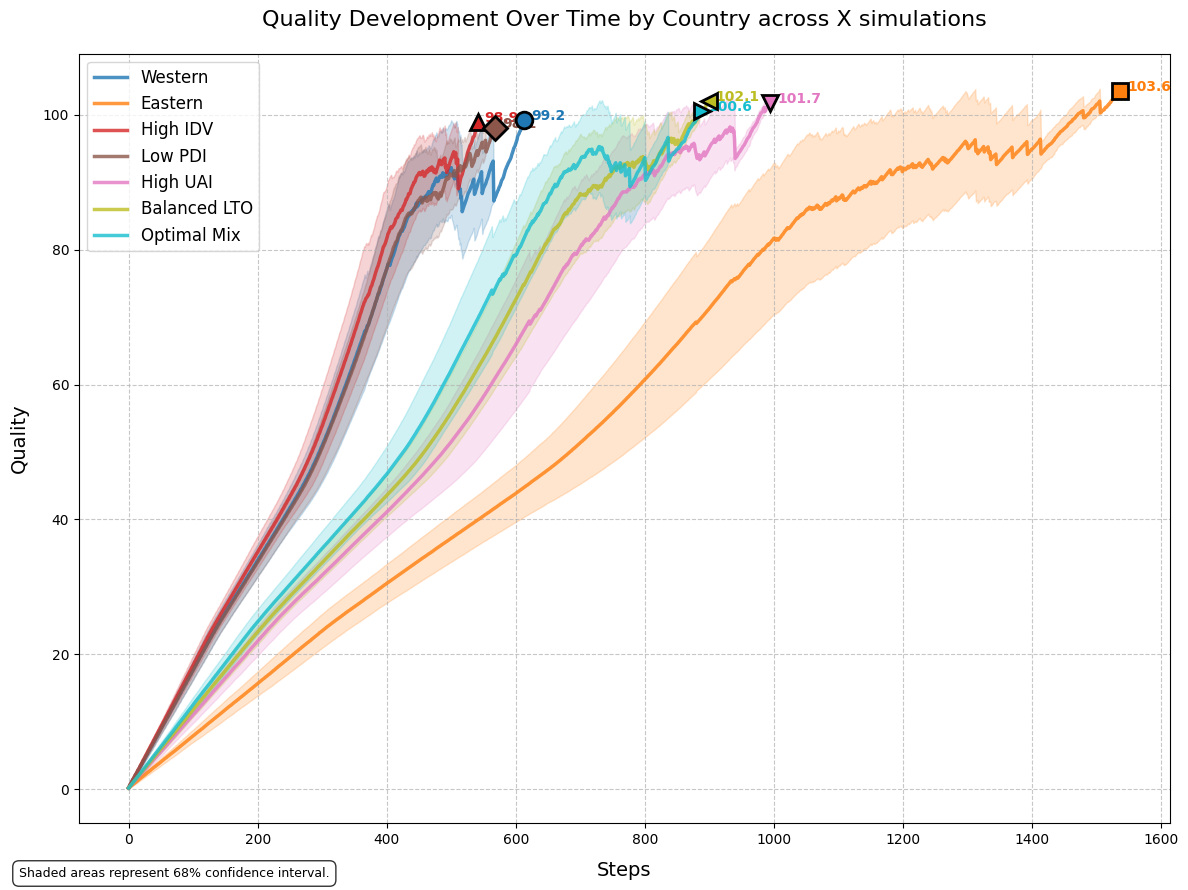

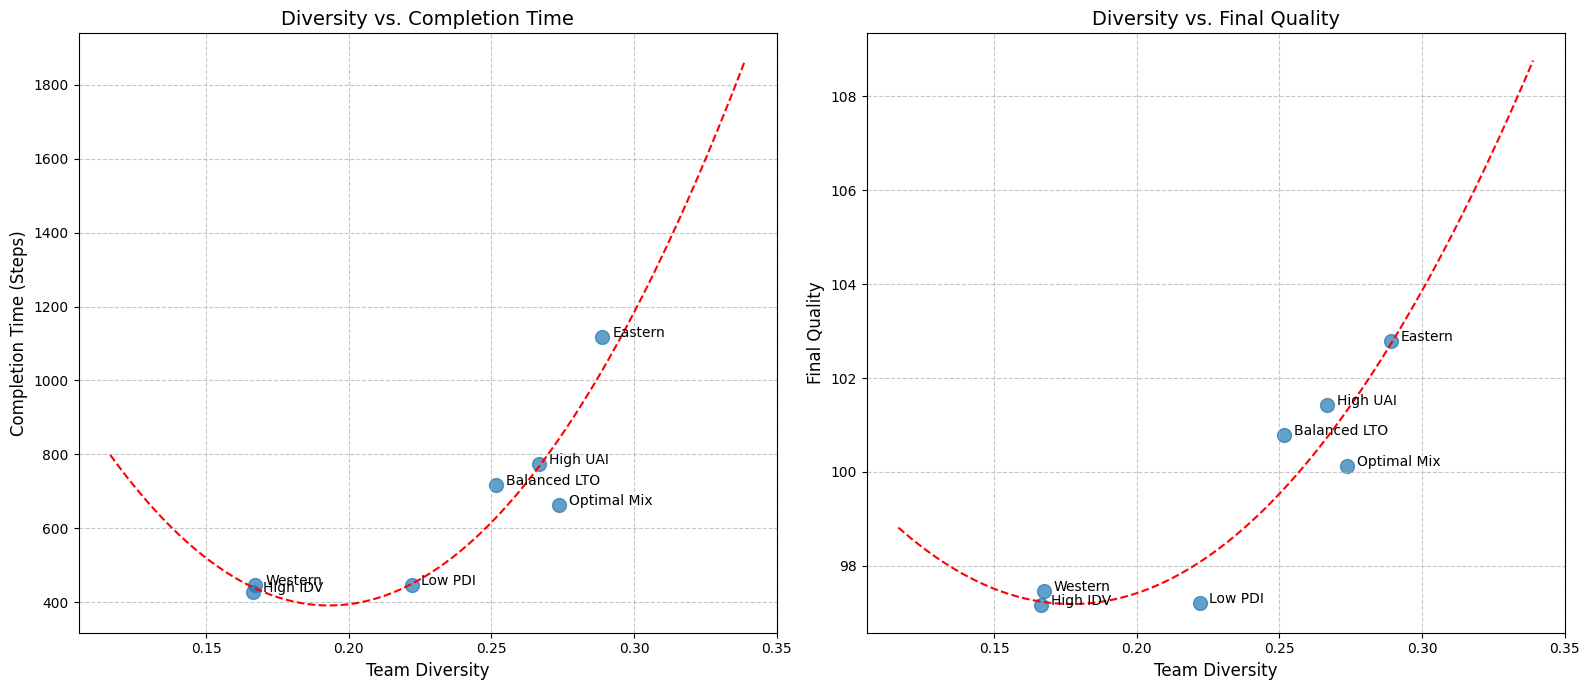

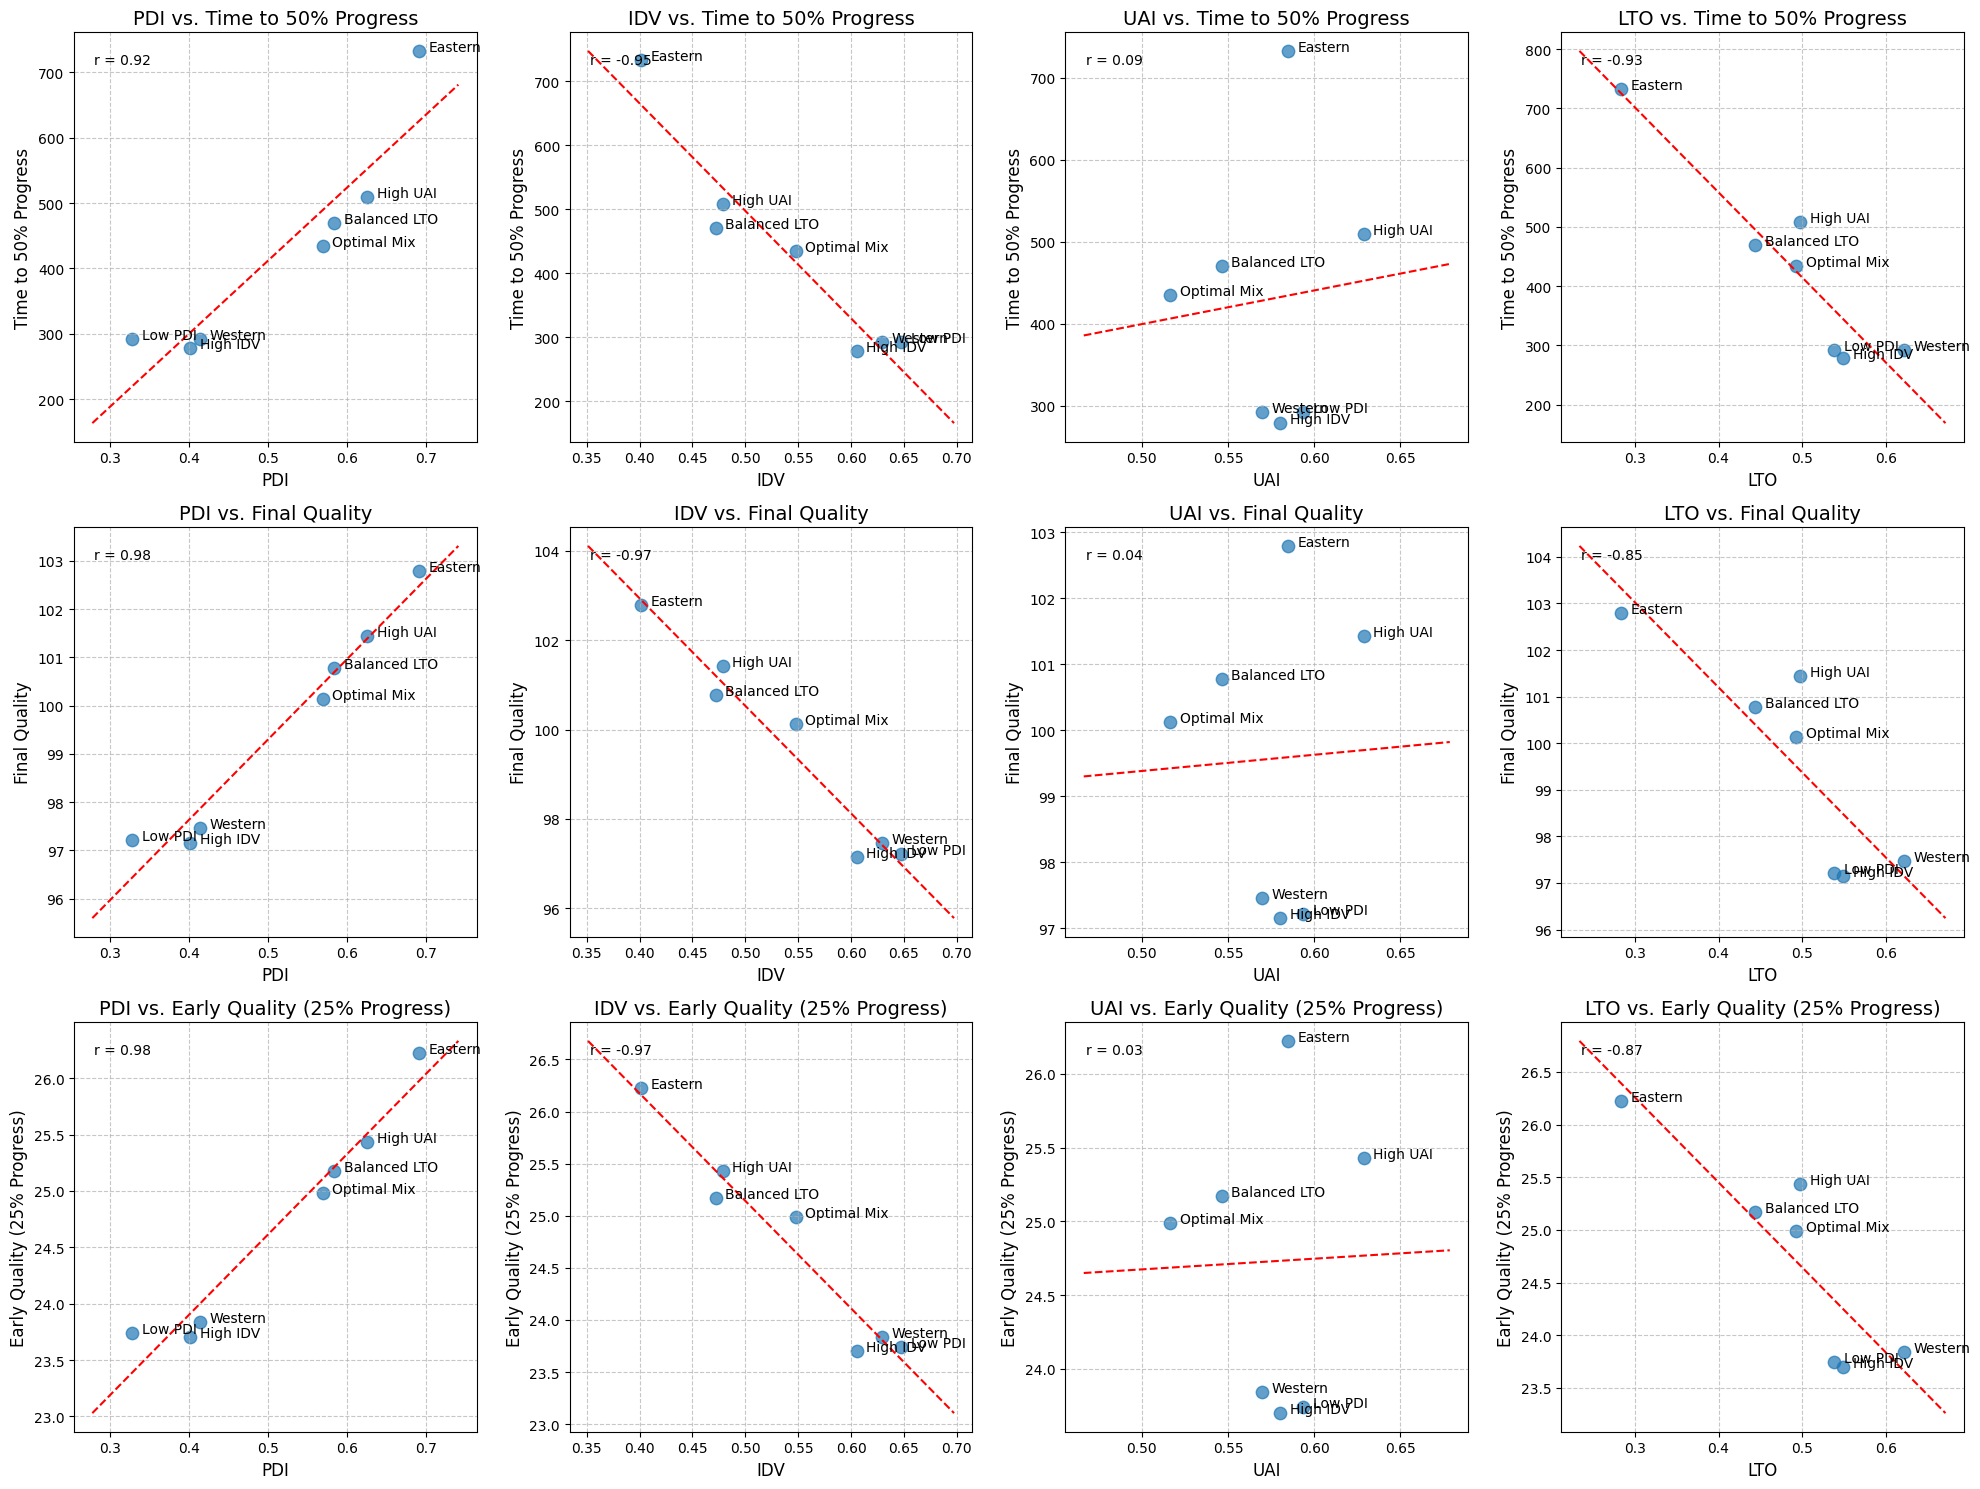

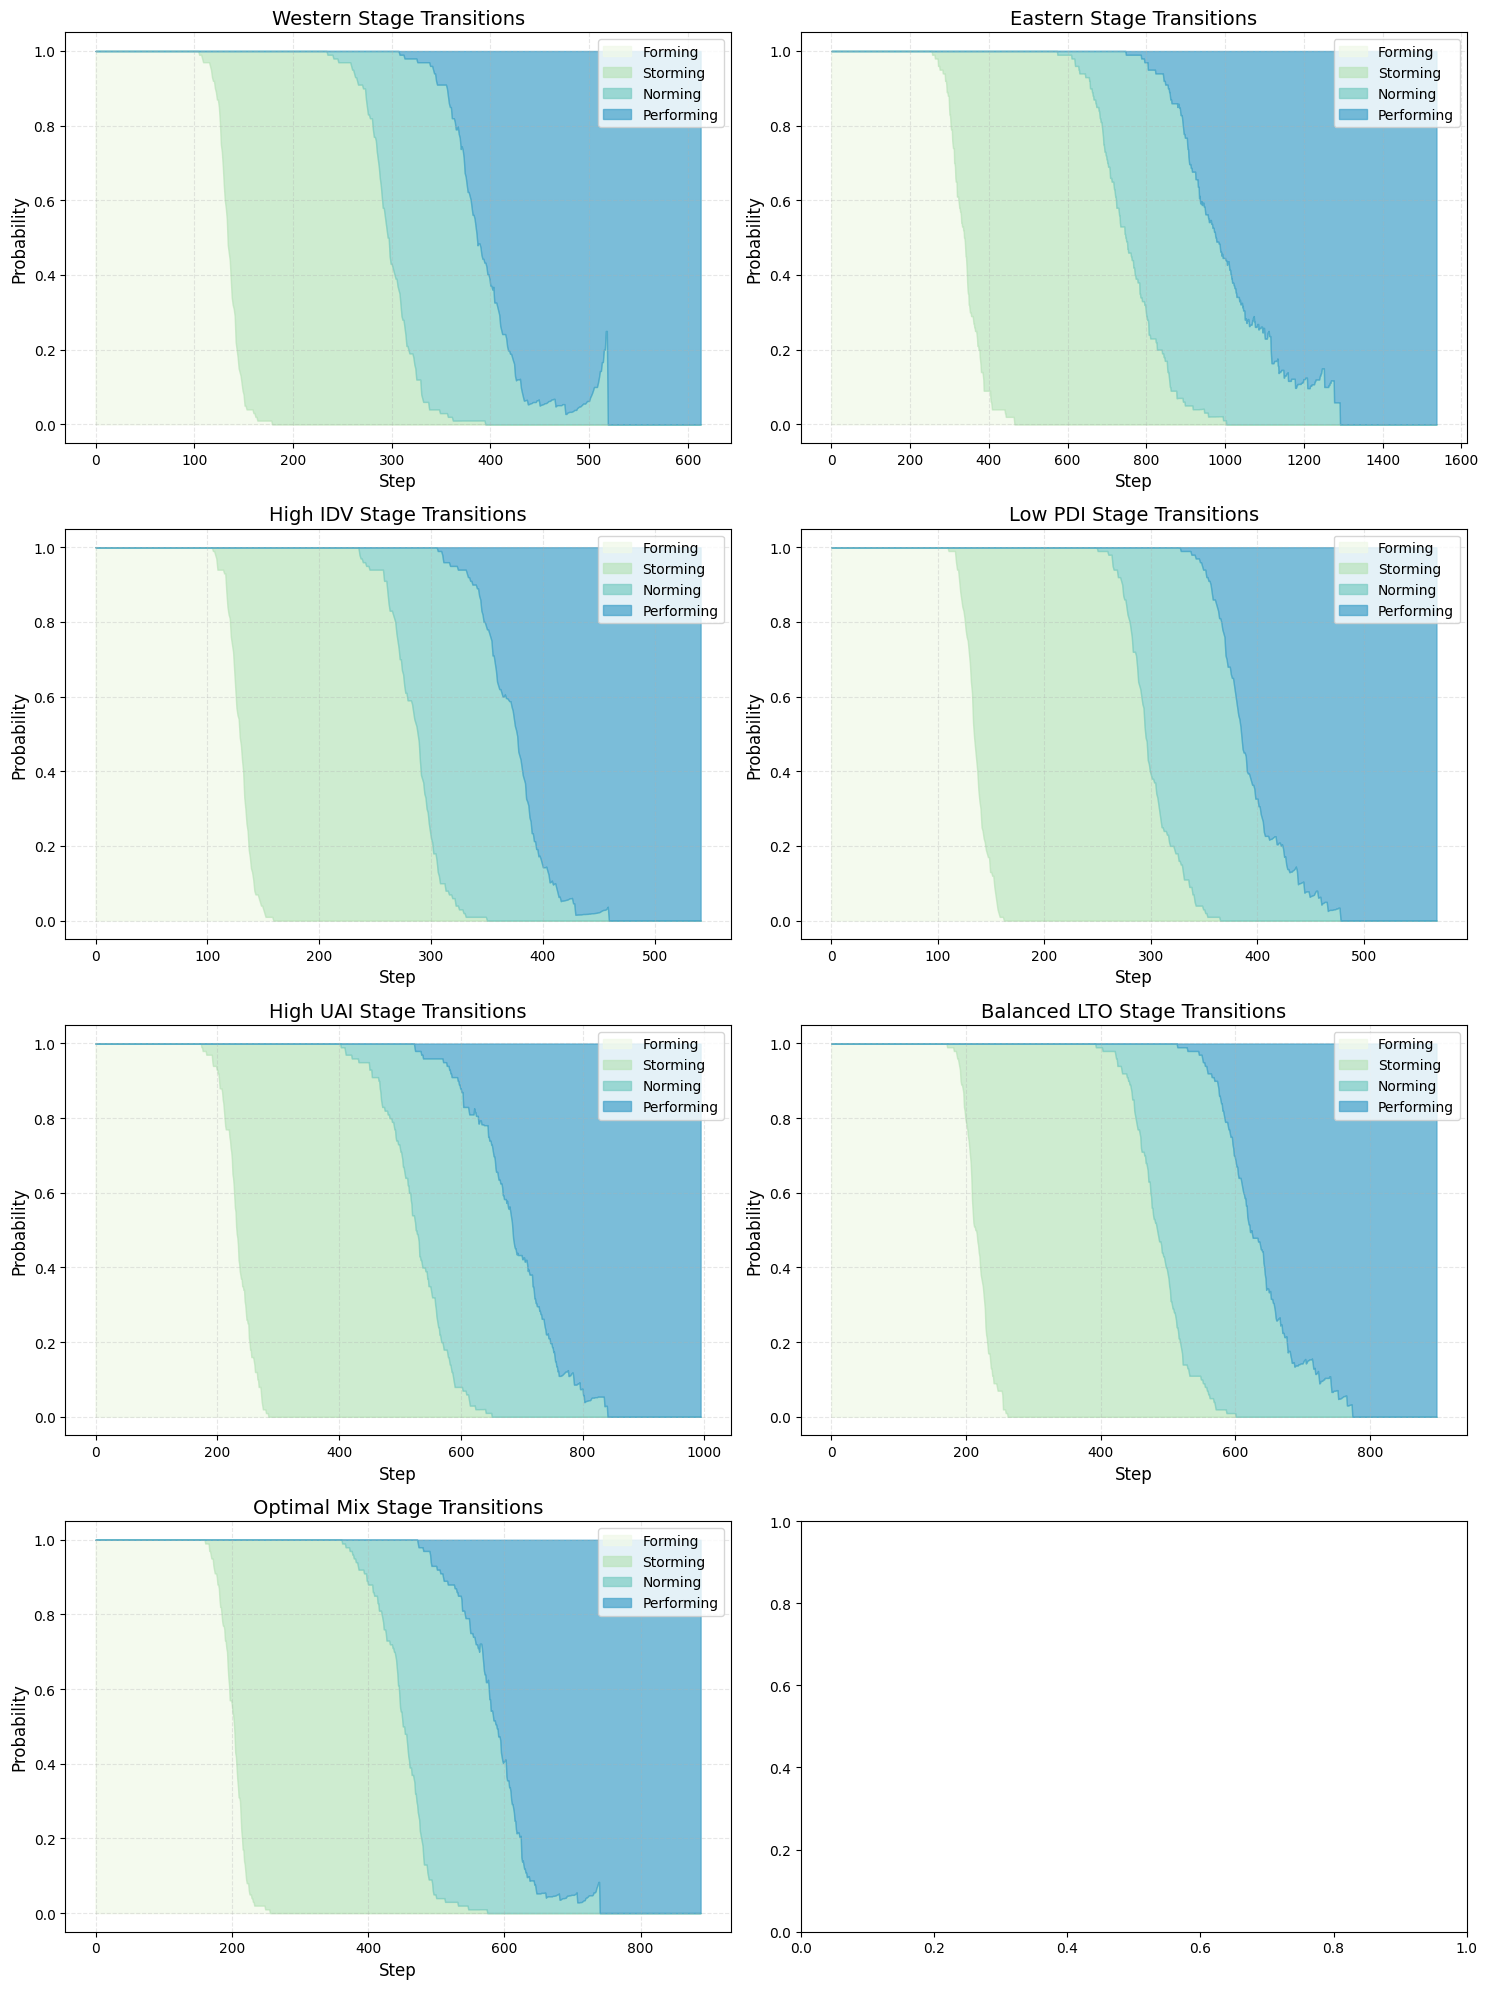

In [15]:
# Now create all the plots
quality_progress_plot = create_quality_vs_steps_plot(team_generators, quality_runs)
diversity_plots = create_diversity_performance_plots(team_generators, progress_runs, quality_runs, team_diversity_results)
correlation_plots = create_cultural_correlation_plots(team_generators, progress_runs, quality_runs)
stage_transition_plot = create_stage_transition_plot(team_generators, stage_runs)